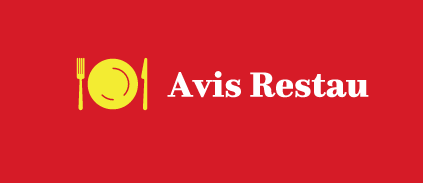

In [ ]:
base_path = 'C:/Users/eloif/hddD/P6 voila dashboard/'#'C:\Users\eloif\hddD'
base_path = ''#'C:\Users\eloif\hddD'

In [ ]:
#pip install pyLDAvis

In [ ]:
#pip install -U opencv-python

In [ ]:
from ipywidgets import *
from IPython.display import display
from random import randrange

In [ ]:
import json
import pandas as pd
import numpy as np

In [ ]:
from PIL import Image
import glob
import os

In [ ]:
from random import randrange
import cv2

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#import pyLDAvis
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X

In [ ]:
def exemple_lda(idx):
  print(comments_usefull8[idx])
  list_topic_attribution = lda.transform(bag_of_words[idx])
  max_index_row = np.argmax(list_topic_attribution, axis=1)
  max_value_row = np.max(list_topic_attribution, axis=1)
  print("this comment is near the topic \""+str(max_index_row)+"\" with probability of \""+str(max_value_row)+"\"")

In [ ]:
def plot_topics(words,components):
  for comp in components:
    df_plot = pd.DataFrame(words,comp).sort_index().tail(10)
    #display(df_plot)
    # plot
    df_plot["freq"] = df_plot.index
    df_plot["words"] = df_plot[0]
    sns.barplot(data=df_plot, y="freq", x="words")
    plt.show()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
def apply_fun_2_folders(func, folders = ['drink','food','interior','outside','menu'], nb_res_func = 1, len_each_folder = 1000, base_path = base_path+'data/yelp_photos/train/'):
  res = []
  res2 = []
  if nb_res_func == 1:
    for classe in folders:
      func_return = func(base_path+classe+'/*.jpg', len=len_each_folder)
      res.append(func_return)
    res_unested = [item for sublist in res for item in sublist]
    return res_unested
  elif nb_res_func == 2:
    for classe in folders:
      func_return1,func_return2 = func(base_path+classe+'/*.jpg', len=len_each_folder)
      res.append(func_return1)
      res2.append(func_return2)
    res_unested = [item for sublist in res for item in sublist]
    res2_unested = [item for sublist in res2 for item in sublist]
    return res_unested,res2_unested
  else: print("error no > 2 returns values for func"); return 0

In [ ]:
def order_img_file(pathInput,pathOutput,list_fileName_class):
  #assuming jpg
  #create folders with class names before
  for filename in glob.glob(pathInput): 
    imgID = os.path.basename(os.path.splitext(filename)[0])
    #print(imgID)
    #print(list_fileName_class[list_fileName_class["photo_id"] == imgID])
    if len(list_fileName_class[list_fileName_class["photo_id"] == imgID]) != 0:
      imgLABEL = list_fileName_class[list_fileName_class["photo_id"] == imgID]["label"].values[0]
      os.replace(filename, pathOutput+imgLABEL+"/"+imgID+".jpg")
    else: print("Error for file: "+imgID)

In [ ]:
def read_img_and_get_labels(path,len = 1000):
  # df = dictionary file_name <=> class
  image_list = []
  list_img_labels = []
  i = 0
  for filename in glob.glob(path): #assuming jpg
    im=Image.open(filename)
    
    imgID = os.path.basename(os.path.splitext(filename)[0])
    #print(imgID)
    #print(df[df["photo_id"] == imgID].shape[0])
    if df[df["photo_id"] == imgID].shape[0] != 0:
      imgLABEL = df[df["photo_id"] == imgID]["label"].values[0]
      list_img_labels.append(imgLABEL)
      image_list.append(im)
    else: print("Error for file: "+imgID)
    i += 1
    if i >= len: break
  return image_list,list_img_labels
  
def read_img_to_GRAY(path, len = 1000):
  # df = dictionary file_name <=> class
  list_img_gray = []
  i = 0
  for filename in glob.glob(path): #assuming jpg
    rgb_l = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
    imgID = os.path.basename(os.path.splitext(filename)[0])
    if df[df["photo_id"] == imgID].shape[0] != 0:
      list_img_gray.append(gray_l)
    else: print("Error for file: "+imgID)
    i += 1
    if i >= len: break
  return list_img_gray

def img_to_SIFTdescriptor(list_img_gray):
  feature_extractor = cv2.SIFT_create(200)
  #feature_extractor = cv2.xfeatures2d.SIFT_create()
  list_img_descriptor = []
  list_img_keyP = []
  for img in list_img_gray:
    keypoint, descriptor = feature_extractor.detectAndCompute(img, None)
    list_img_descriptor.append(descriptor)
    list_img_keyP.append(keypoint)
  return list_img_keyP,list_img_descriptor

def SIFTdescriptor_to_centroid(list_descriptor, model):
  # model = kmeans model on all SIFT descriptors
  list_img_centroid = []
  for img in list_descriptor:
    list_centroid = []
    for descriptor in img:
      centroid = model.predict([descriptor])
      list_centroid.append(centroid)
    list_img_centroid.append(list_centroid)
  return list_img_centroid

def SIFTcentroid_to_hist(list_img_centroid):
  list_img_hist = []
  for img in list_img_centroid:
    count_visw = []
    for visual_word in range(nb_visual_word):
      count_visw.append(img.count(visual_word))
    list_img_hist.append(count_visw)
  return list_img_hist

# Analyse de commentaires

In [ ]:
filename = base_path+'data/yelp_academic_dataset_review.json'
datas = []
nb_line = 100000
i=0
for line in open(filename, encoding="utf8"):
  i+=1
  #print(line)
  if i > nb_line: break
  data = json.loads(line)
  datas.append(data)
  
df = pd.DataFrame(datas)

FileNotFoundError: ignored

In [ ]:
mask1 = df["useful"] > 1
mask2 = df["stars"] < 4

In [ ]:
df_usefull = df[mask1 & mask2]
comments_usefull = df_usefull["text"]

In [ ]:
import re

In [ ]:
comments_usefull2 = comments_usefull.map(lambda x: re.sub('[,\".!?(;)]', '', x))

In [ ]:
comments_usefull3 = comments_usefull2.map(lambda x: x.lower())

In [ ]:
comments_usefull4 = comments_usefull3.map(lambda x: x.replace('\n', ' '))

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

In [ ]:
comments_usefull5 = [nltk.word_tokenize(comment) for comment in comments_usefull4]

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
comments_usefull6 = []
for comment in comments_usefull5:
  comments_usefull6.append([lemmatizer.lemmatize(word) for word in comment])

In [ ]:
words = set(nltk.corpus.words.words())

In [ ]:
words.remove("wa")
# Washington = "wa" ?
words.remove("did")
# did =/=> do ?

In [ ]:
comments_usefull7 = []
for comment in comments_usefull6:
  comments_usefull7.append([word for word in comment if word.lower() in words or not word.isalpha()])

In [ ]:
comments_usefull8 = []
for comment in comments_usefull7:
  comments_usefull8.append(' '.join(comment))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
# ignore words that appear in less than 3 of the articles
vectorizer = TfidfVectorizer(min_df=3, stop_words='english', max_features=1000)
bag_of_words = vectorizer.fit_transform(comments_usefull8)


In [ ]:
exemple1 = bag_of_words[0].toarray()[0]

In [ ]:
features_array = np.array(vectorizer.get_feature_names())

### Les mots les plus utilisés

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(comments_usefull8)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=10)
lsa = svd.fit_transform(bag_of_words)

In [ ]:
topic_labels = ["topic"+str(i+1) for i in range(10)]

In [ ]:
topics_tfidf_df = pd.DataFrame(lsa, columns = topic_labels)

In [ ]:
topics_tfidf_df["comments"] = comments_usefull8

In [ ]:
encoding_matrix = pd.DataFrame(svd.components_, index = topic_labels).T
encoding_matrix["mots"] = vectorizer.get_feature_names()

In [ ]:
def topic_top_words(encoding_matrix, topic_label = "topic1", nb_words=50):
  res = encoding_matrix.sort_values(topic_label).tail(nb_words)
  return res["mots"]

In [ ]:
def display_wordcloud(list_wordcloud, nb_topics = 10):
    fig = plt.figure(figsize=[18,12],tight_layout=True)
    i = 1
    nb_lines = (nb_topics-1)//5+1
    for wc in list_wordcloud:
        plt.subplot(nb_lines, 5, i).set_title("Topic #" + str(i))
        plt.plot()
        plt.imshow(wc)
        plt.axis("off")
        i += 1
    fig.suptitle("Topic's top words")
    plt.show()

In [ ]:
df_topics_lsa = pd.DataFrame(columns=topic_labels)
list_wordcloud = []
for i in range(10):
  res = topic_top_words(encoding_matrix, topic_label = "topic"+str(i+1))
  df_topics_lsa["topic"+str(i+1)] = res
  #print(res)
  #display(res)
  long_string = ','.join(res)# Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')# Generate a word cloud
  wordcloud.generate(long_string)# Visualize the word cloud
  list_wordcloud.append(wordcloud.to_image())

### Topics (LSA) 

In [ ]:
def setup_ui(txt):
    out = widgets.Output()
    with out:
        print(txt)
    return out

def setup_ui_img(img):
    out = widgets.Output()
    with out:
      #print("test")
      plt.plot()
      plt.imshow(img)
      plt.show()
    return out

In [ ]:
liste_choix_topic = widgets.Dropdown(
    options=[('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6), ('7', 7), ('8', 8), ('9', 9), ('10', 10)],
    value=1,
    description='Topic to display:',
)

def f_choix_topic(arg):
        #display2("changed to %s" % arg['new'])
        #print(list_wordcloud[arg['new']-1])
        #txt_out = setup_ui(arg)
        img_out = setup_ui_img(list_wordcloud[arg['new']-1])
        
        #plt.plot()
        #plt.imshow(list_wordcloud[arg['new']-1])
        final_layout.children = [img_out]

liste_choix_topic.observe(f_choix_topic, 'value')

display(liste_choix_topic)

Dropdown(description='Topic to display:', options=(('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6),…

In [ ]:
final_layout = widgets.VBox()
final_layout

VBox()

In [ ]:
#display_wordcloud(list_wordcloud)

In [ ]:
res = []
for n_comp in [2,10,20,50,100,200,500]:
  svd2 = TruncatedSVD(n_components=n_comp)
  lsa2 = svd2.fit_transform(bag_of_words)
  res.append(svd2.explained_variance_ratio_.sum())

In [ ]:
tmp = encoding_matrix.sort_values("topic2").tail(10)
tmp2 = encoding_matrix.sort_values("topic1").tail(10)
data_plt = tmp.append(tmp2)

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], str(point['val']))
    return ax

In [ ]:
data_plt["related_to"] = "topic1"
i = 0
for line in data_plt.iterrows():
  if i < 10: data_plt["related_to"].iloc[i] = "topic2"
  i += 1

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
n_topics = 10

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

lda.fit(bag_of_words)
#display_topics(lda, vectorizer.get_feature_names(), 10)
#plot_topics(vectorizer.get_feature_names(),lda.components_)

### Topics (LDA)

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
pyLDAvis.sklearn.prepare(lda, bag_of_words, vectorizer)

**Remarque:** 
+ Plus un cercle est gros, plus le topic qu'il represente est populaire
+ Plus les cercle sont eloignés, plus les topics qu'ils representent sont differents
+ λ faible = visualisation des mots specifique au topic selectionné
+ λ fort = visualisation des mots les plus frequent dans le topic selectionné


# Analyse de photos

In [ ]:
filename = base_path+'data/yelp_photos/photos.json'

In [ ]:
datas = []
for line in open(filename, encoding="utf8"):
  data = json.loads(line)
  datas.append(data)
  
df = pd.DataFrame(datas)

In [ ]:
pathInput = base_path+'data/yelp_photos/train/*.jpg'
pathOutput = base_path+'data/yelp_photos/train/'
order_img_file(pathInput,pathOutput,df)

In [ ]:
pathInput = base_path+'data/yelp_photos/test/*.jpg'
pathOutput = base_path+'data/yelp_photos/test/'
order_img_file(pathInput,pathOutput,df)

In [ ]:
# load 200 images of each class
image_list,list_img_labels = apply_fun_2_folders(read_img_and_get_labels,nb_res_func=2)

In [ ]:
list_img_gray = apply_fun_2_folders(read_img_to_GRAY,nb_res_func=1)

In [ ]:
from random import shuffle

In [ ]:
# shuffle to keep same number of class in subset (for later)
abc = list(zip(image_list, list_img_labels, list_img_gray))

shuffle(abc)

image_list, list_img_labels, list_img_gray = zip(*abc)


### Exemple photo/label 

In [ ]:
button = widgets.Button(
    description='Random image',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reload another image from dataset',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def foo(arg):
  idx = randrange(0,2000)
  img_out = setup_ui_img(image_list[idx])
  txt_out = setup_ui("Label = "+list_img_labels[idx])
  final_layout2.children = [img_out,txt_out]

button.on_click(foo)

display(button)

In [ ]:
final_layout2 = widgets.VBox()
final_layout2

In [ ]:
list_img_keyP,list_img_descriptor = img_to_SIFTdescriptor(list_img_gray)

In [ ]:
# todo does it work ?

In [ ]:
from sklearn.cluster import KMeans


In [ ]:
flat_list = [item for sublist in list_img_descriptor for item in sublist]

In [ ]:
flat_list_light = flat_list[:1000000]

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
nb_visual_word = 60
# 10 * nb_class <= nb_visual_word <= sqrt(nb_sift)
#      50       <= nb_visual_word <=     1000
# https://datascience.stackexchange.com/questions/16143/what-is-the-procedure-to-create-a-bag-of-visual-words-model-with-sift
# https://register.gotowebinar.com/recording/5532038138285671435

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=nb_visual_word,
                         random_state=0).fit(flat_list_light)

In [ ]:
#kmeans = KMeans(n_clusters=nb_visual_word, random_state=0).fit(flat_list_light)


In [ ]:
visual_words = kmeans.cluster_centers_

In [ ]:
# todo prend = 38min

In [ ]:
list_img_centroid = SIFTdescriptor_to_centroid(list_img_descriptor, model = kmeans)

In [ ]:
#2h20

In [ ]:
list_img_hist = SIFTcentroid_to_hist(list_img_centroid)

In [ ]:
def display_img_hist(idx):
  sns.scatterplot(data=list_img_hist[idx])
  plt.title('Freq of each visual words')
  plt.xlabel('visual word ID')
  plt.ylabel('number of each')
  plt.show()

In [ ]:
image_list_test,list_img_labels_test = read_img_and_get_labels(base_path+'data/yelp_photos/test/*/*.jpg')

In [ ]:
list_img_gray_test = read_img_to_GRAY(base_path+'data/yelp_photos/test/*/*.jpg')


In [ ]:
list_img_keyP_test,list_img_descriptor_test = img_to_SIFTdescriptor(list_img_gray_test)


In [ ]:
list_img_centroid_test = SIFTdescriptor_to_centroid(list_img_descriptor_test, model = kmeans)


In [ ]:
list_img_hist_test = SIFTcentroid_to_hist(list_img_centroid_test)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
pca.fit(list_img_hist)


In [ ]:
list_img_hist_reduced = pca.fit_transform(list_img_hist)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
# doc: perplexity = Consider selecting a value between 5 and 50
list_img_hist_reduced2 = TSNE(n_components=2, perplexity=50).fit_transform(list_img_hist_reduced)


In [ ]:
df_img_vis = pd.DataFrame()

In [ ]:
df_img_vis['PC1'] = list_img_hist_reduced2[:,0]
df_img_vis['PC2'] = list_img_hist_reduced2[:,1] 
df_img_vis['label'] = list_img_labels


### Representation des images en 2D (t-SNE)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="label",
    data=df_img_vis,
    legend="full",
    alpha=0.3
)